In [28]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Serialization needs to use dill instead of pickle
# if custom functions are used.
import dill as pickle

In [29]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.5
sim.parameters["n_variants"] = 20

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
@mr_sim.variable
def x_e_variance(sim):
    """Variance for the environmental component of the exposure."""
    target = 1 - sim.parameters["h2"] - sim.parameters["ux_effect"] ** 2
    if target < 0:
        raise ValueError("Unacheivable value.")
    return target
sim.add_sim_parameter(x_e_variance)

sim.parameters["y_e_std"] = 1

In [30]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
        0.2,
        0.4,
        size=sim.get_sim_parameter("n_variants")
        # equivalently: sim.parameters["n_variants"]
    )
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
variants = []
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    variants.append(variant)

sim.add_variables(variants)

# We simulate variant effects.
# Note that these effects will yield the desired heritability
# only if var(g) = 1 (i.e. if the variants have been scaled).
sim.add_sim_parameter(
    mr_sim.Normal(
        "gx_effects",
        mu=0,
        sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
        size=sim.parameters["n_variants"]
    )
)
    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        scaled_variant = (variant - np.mean(variant)) / np.std(variant)
        effect = variant_effects[i]
        
        x += effect * scaled_variant
        
    print("Var_G = {}".format(np.var(x)))
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(
        0,
        scale=np.sqrt(sim.parameters["x_e_variance"]),
        size=sim.n
    )
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

Var_G = 0.6139784622674717


In [31]:
# Simulations can be saved to disk as pairs of JSON + CSV files.
# The JSON contains simulation parameters and the CSV files contains
# simulated data.
sim.save(0)

# The resample method can be used to run the simulation again.
sim.resample()
sim.save(1)
!ls

Var_G = 0.2851671694949743
basic_simulation_model.ipynb
bin_iv_varying_h2
mr_simulation_0_simulation_data.csv.gz
mr_simulation_0_simulation_parameters.json
mr_simulation_1_simulation_data.csv.gz
mr_simulation_1_simulation_parameters.json
sim.pkl


In [32]:
# The individual level data is stored as a pandas dataframe.
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,1.015200,0,1,2,0,0,1,0,0,0,...,0,2,0,0,0,1,1,0,-0.455746,-2.099064
1,2.650221,1,1,1,1,1,0,1,1,1,...,1,0,0,2,0,0,0,1,0.768721,-3.369456
2,-1.762871,1,1,0,1,1,1,1,0,1,...,0,0,0,1,0,0,2,0,-1.703710,2.886667
3,0.262168,0,0,1,0,1,1,1,1,0,...,2,1,0,0,1,1,1,1,0.751876,-0.234047
4,-2.485587,1,1,0,0,1,0,0,1,0,...,0,1,1,0,1,0,0,0,0.409608,3.292492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.881300,2,0,2,1,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1.617315,0.819156
99996,1.931438,1,0,0,1,1,0,0,0,1,...,1,0,1,1,1,1,0,0,0.400718,-0.992737
99997,0.279497,0,0,0,1,0,1,0,1,0,...,0,1,1,1,0,0,1,1,1.252964,-0.696036
99998,0.316488,0,2,1,0,1,0,0,2,1,...,2,1,0,0,1,1,1,1,0.702826,0.227990


In [33]:
# Check how close we are to the desired heritability.
res = sm.OLS(
    sim.get_variable_data("exposure"),
    sm.add_constant(  # Adds intercept
        sim._data[[f"v{i+1}" for i in range(15)]]
    )
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               exposure   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     2410.
Date:                Thu, 23 Feb 2023   Prob (F-statistic):               0.00
Time:                        09:19:01   Log-Likelihood:            -1.1413e+05
No. Observations:              100000   AIC:                         2.283e+05
Df Residuals:                   99984   BIC:                         2.284e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4073      0.009    -47.274      0.000      -0.424      -0.390
v1            -0.0479      0.004    -12.379      0.000      -0.056      -0.040
v2            -0.0651      0.004    -18.426      0.000      -0.072      -0.058
v3             0.2019      0.004     48.199      0.000       0.194       0.210
v4             0.0342      0.004      8.680      0.000       0.026       0.042
v5             0.3016      0.004     76.403      0.000       0.294       0.309
v6             0.0765      0.004     20.483      0.000       0.069       0.084
v7            -0.3141      0.004    -74.716      0.000      -0.322      -0.306
v8             0.3851      0.004    108.458      0.000       0.378       0.392
v9            -0.1029      0.004    -28.477      0.000      -0.110      -0.096
v10           -0.1673      0.004    -42.602      0.000      -0.175      -0.160
v11            0.2319      0.004     56.981      0.000       0.224       0.240
v12           -0.0278      0.004     -7.494      0.000      -0.035      -0.021
v13            0.1350      0.004     37.129      0.000       0.128       0.142
v14           -0.1079      0.004    -29.730      0.000      -0.115      -0.101
v15            0.1420      0.004     39.361      0.000       0.135       0.149
==============================================================================
Omnibus:                        0.229   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.892   Jarque-Bera (JB):                0.224
Skew:                          -0.003   Prob(JB):                        0.894
Kurtosis:                       3.003   Cond. No.                         9.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

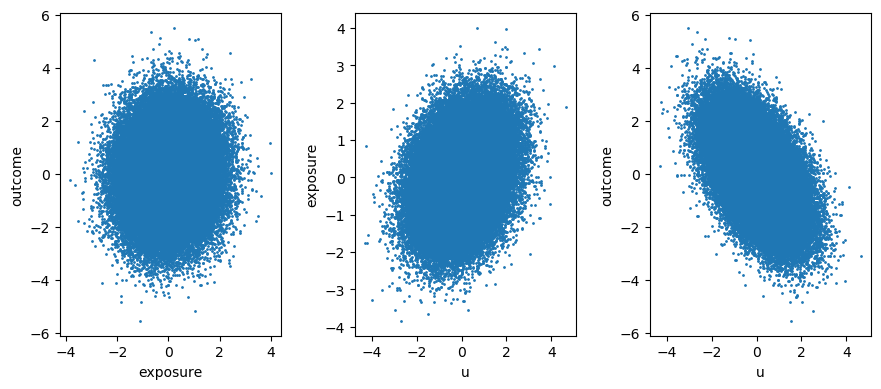

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()

In [35]:
# Simulations can be saved using the "dill" package.
# This allows easy sharing of simulation models.
# The original data will be saved.
sim.save_pickle("sim.pkl")
sim2 = mr_sim.Simulation.load_pickle("sim.pkl")
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,1.015200,0,1,2,0,0,1,0,0,0,...,0,2,0,0,0,1,1,0,-0.455746,-2.099064
1,2.650221,1,1,1,1,1,0,1,1,1,...,1,0,0,2,0,0,0,1,0.768721,-3.369456
2,-1.762871,1,1,0,1,1,1,1,0,1,...,0,0,0,1,0,0,2,0,-1.703710,2.886667
3,0.262168,0,0,1,0,1,1,1,1,0,...,2,1,0,0,1,1,1,1,0.751876,-0.234047
4,-2.485587,1,1,0,0,1,0,0,1,0,...,0,1,1,0,1,0,0,0,0.409608,3.292492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.881300,2,0,2,1,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1.617315,0.819156
99996,1.931438,1,0,0,1,1,0,0,0,1,...,1,0,1,1,1,1,0,0,0.400718,-0.992737
99997,0.279497,0,0,0,1,0,1,0,1,0,...,0,1,1,1,0,0,1,1,1.252964,-0.696036
99998,0.316488,0,2,1,0,1,0,0,2,1,...,2,1,0,0,1,1,1,1,0.702826,0.227990


In [36]:
# And resampling should also work as expected!
sim2.resample()
sim2._data

Var_G = 0.46151469967853964


,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v13,v14,v15,v16,v17,v18,v19,v20,exposure,outcome
0,-0.101222,2,0,1,1,1,0,0,0,1,...,1,0,1,0,0,2,0,1,1.126671,-0.065437
1,1.239787,0,2,0,0,0,0,0,1,0,...,1,0,1,1,1,1,2,2,-0.779482,-1.626624
2,-0.817331,1,0,0,0,0,0,0,1,1,...,0,1,2,0,0,1,0,0,0.693425,1.129512
3,0.447309,1,1,0,1,0,0,0,1,0,...,1,0,1,0,0,2,0,0,1.268951,1.280451
4,0.330071,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,1,0,1,-0.558255,-0.644132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.637942,0,2,0,0,0,0,0,0,1,...,1,0,0,0,0,1,1,0,-0.051630,-1.195919
99996,-1.228203,0,1,0,0,0,0,0,0,1,...,1,1,2,1,1,0,1,0,0.156170,-0.239769
99997,-0.621449,0,2,0,1,0,2,0,1,0,...,2,0,2,2,0,1,1,1,-1.006546,0.995859
99998,-1.983414,0,1,0,0,0,1,0,0,0,...,1,2,0,2,1,2,0,0,-3.350902,2.267112
